In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "moustafasamy" # username from the json file
os.environ['KAGGLE_KEY'] = "cc254a16109504e24f74b11aa56bc3c1" # key from the json file
!kaggle datasets download -d nabeelsajid917/covid-19-x-ray-10000-images # api copied from kaggle

 90% 83.0M/92.7M [00:01<00:00, 45.1MB/s]
100% 92.7M/92.7M [00:01<00:00, 64.1MB/s]


In [2]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [8]:
DATASET_DIR = "/content/covid-19-x-ray-10000-images.zip"
!unzip covid-19-x-ray-10000-images.zip

Archive:  covid-19-x-ray-10000-images.zip
replace covid19.model? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: covid19.model           
replace dataset/covid/covid (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/covid/covid (1).jpeg  
replace dataset/covid/covid (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/covid/covid (1).jpg  
replace dataset/covid/covid (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/covid/covid (1).png  
  inflating: dataset/covid/covid (10).jpeg  
  inflating: dataset/covid/covid (10).jpg  
  inflating: dataset/covid/covid (10).png  
  inflating: dataset/covid/covid (11).jpeg  
  inflating: dataset/covid/covid (11).jpg  
  inflating: dataset/covid/covid (11).png  
  inflating: dataset/covid/covid (12).jpeg  
  inflating: dataset/covid/covid (12).jpg  
  inflating: dataset/covid/covid (13).jpeg  
  inflating: dataset/covid/covid (13).jpg  
  inflating: dataset/covid/covid (14).jpeg  
  infl

In [9]:
os.listdir("/content/generated_dataset")

['normal', 'covid']

In [12]:

#IPython display
import IPython.display as display
from PIL import Image

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__) 

# Helper libraries
import os
import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

2.2.0-rc2


In [0]:
# Set working directory
root_dir = Path.cwd()
PATH = str(root_dir / 'generated_dataset')
data_dir = pathlib.Path(PATH)

In [14]:
# Check image count
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

2

In [15]:
# Extract target labels
class_names = np.array([item.name for item in data_dir.glob('*')])
list_labels = list(class_names)
class_names

array(['normal', 'covid'], dtype='<U6')

In [16]:
# View sample image
normal = list(data_dir.glob('normal/*'))
for image_path in normal[:1]:
  print(image_path)
  check_img = Image.open(str(image_path))
  display.display(check_img)
  w,h = check_img.size
  print("original dimensions:{}x{}".format(w,h))

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Use tf.data.Dataset to create a TF dataset in the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
type(list_ds)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [0]:
# Break the path to components
def get_label(file_path):
  parts = tf.strings.split(file_path, sep = os.path.sep )
  #observe that the second last component is the name of the class
  return parts[-2] == class_names


In [0]:
# Decoding image to tensor and resize
IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 16

def decode_img(img):
  #convert the image to a 3D tensor
  img = tf.image.decode_jpeg(img, channels = 3)
  #Use `convert_image_dtype` to convert to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [0]:
# Finally club the desired operations
def process_path(file_path):
  label = get_label(file_path)
  #load the data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


In [0]:
# TF map the above function to apply transformations to all samples in the dataset
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE) 

In [22]:
for image, label in labeled_ds.take(1):
    print(image.shape)

(224, 224, 3)


In [23]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label:", label.numpy())
    print(type(label))

Image shape:  (224, 224, 3)
Label: [False  True]
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat(count=1)

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

In [0]:
# Plot a batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      title = plt.title(class_names[label_batch[n]==1][0].title())
      plt.setp(title, color = 'y')  
      plt.axis('off')

IndexError: ignored

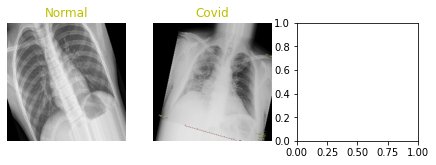

In [27]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
# check the number of elements in the dataset
# we have grouped the samples into batches so `cardinality` will consider the number of batches
num_elements = tf.data.experimental.cardinality(train_ds).numpy()
num_elements

1

In [0]:
# perform train/validation split using take/split
val_size = int(.1 * num_elements)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [0]:
# create base (no-brainer) model
cd_model = Sequential([
    Conv2D(8, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Flatten(),
    Dense(2, activation='sigmoid')
])

In [0]:
# compile the model
cd_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
# check the model summary
cd_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 200706    
Total params: 200,930
Trainable params: 200,930
Non-trainable params: 0
_________________________________________________________________


In [41]:
# finally fit the model
epochs = 3
history = cd_model.fit_generator(
    train_ds,
    epochs=epochs,
    validation_data = val_ds,
    verbose = 1,
    initial_epoch = 0
)

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 1.0000

UnboundLocalError: ignored

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

acc_fig = plt.figure(figsize=(6, 6))
acc_ax = acc_fig.add_subplot()
acc_ax.tick_params(colors='y')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', color = 'yellow')
plt.show()

loss_fig = plt.figure(figsize= (6, 6))
loss_ax = loss_fig.add_subplot()
loss_ax.tick_params(color= 'y')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', color = 'y')
plt.show()

NameError: ignored